In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle
import os
from multiprocessing import Pool
from math import ceil
from sentence_transformers import SentenceTransformer
# scikit-learn grid search
from sklearn.model_selection import ParameterGrid
from bertopic import BERTopic
from functools import partial
from bert_topic_grid_search import apply_bert_topic
from functools import partial
from numba import jit, cuda

DATA_DIR = 'dataset'

In [2]:
# Read in the data
df = pd.read_csv(f'{DATA_DIR}/full_dataset.csv', nrows=200000)
# Only use the first 100000 rows
#df = df[:100000]

In [3]:
# # find recipes that have directions less than 20 words
# # directions is a list of list of strings
# directions = df['directions'].apply(lambda x: ''.join(x).split())
# # find directions less than 20 words
# idx = directions.apply(lambda x: len(x) < 20)
# print(f'Number of recipes with directions less than 20 words: {idx.sum()}')

In [4]:
# # print some of the short recipes
# print('Some of the short recipes:')
# for i in range(5):
#     print(f'Index: {idx[idx].index[i]}')
#     print(f'Directions: {directions[idx].iloc[i]}')
#     print()

In [5]:
# Extract the directions column as a list of lists of strings
recipes = df['directions'].tolist()
recipes = [eval(recipe) for recipe in tqdm(recipes)]

  0%|          | 0/200000 [00:00<?, ?it/s]

In [6]:
recipe_sentences = [' '.join(recipe) for recipe in tqdm(recipes)]

  0%|          | 0/200000 [00:00<?, ?it/s]

In [7]:
recipe_sentences[:5]

['In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.',
 'Place chipped beef on bottom of baking dish. Place chicken on top of beef. Mix soup and cream together; pour over chicken. Bake, uncovered, at 275° for 3 hours.',
 'In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings.',
 'Boil and debone chicken. Put bite size pieces in average size square casserole dish. Pour gravy and cream of mushroom soup over chicken; level. Make stuffing according to instructions on box (do not make too moist). Put stuffing on top of chicken and gravy; level. Sprinkle shredded cheese on top and bake at 350° for 

In [8]:
# Remove recipes that are less than 100 characters
display(len(recipe_sentences))
recipe_sentences_new = [recipe for recipe in recipe_sentences if len(recipe) > 100]
display(len(recipe_sentences_new))

200000

175281

In [11]:
# print the average length of the recipes
print(f'Average length of the recipes: {np.median([len(recipe) for recipe in recipe_sentences_new])}')

Average length of the recipes: 239.0


In [9]:
# get the first five recipes from df
df_new = df.iloc[:5].copy()

In [10]:
# drop the same recipes from the dataframe
df = df[df['directions'].apply(lambda x: len(' '.join(eval(x)))) > 100]

In [11]:
embedding_model = SentenceTransformer('bert-base-nli-mean-tokens', device='mps')

In [12]:
# Check if embeddings_new.pkl exists
if os.path.exists(f'{DATA_DIR}/embeddings_new.pkl'):
    # Load the embeddings from the pickle file
    with open(f'{DATA_DIR}/embeddings_new.pkl', 'rb') as f:
        embeded_sentences_new = pickle.load(f)
else:
    #embeded_sentences = embedding_model.encode(recipes, show_progress_bar=True)
    # Use multiprocessing to speed up the embedding
    cpu_ratio = 0.8
    cpu_count = ceil(os.cpu_count() * cpu_ratio)
    print(f'Using {cpu_count} cores')
    with Pool(cpu_count) as p:
        embeded_sentences_new = list(tqdm(p.imap(embedding_model.encode, recipe_sentences_new), total=len(recipe_sentences_new)))
    # Save the embeddings
    with open(f'{DATA_DIR}/embeddings_new.pkl', 'wb') as f:
        pickle.dump(embeded_sentences_new, f)

In [13]:
# # Check if embeddings.pkl exists
# if os.path.exists(f'{DATA_DIR}/embeddings.pkl'):
#     # Load the embeddings from the pickle file
#     with open(f'{DATA_DIR}/embeddings.pkl', 'rb') as f:
#         embeded_sentences = pickle.load(f)
# else:
#     #embeded_sentences = embedding_model.encode(recipes, show_progress_bar=True)
#     # Use multiprocessing to speed up the embedding
#     cpu_ratio = 1.0
#     cpu_count = ceil(os.cpu_count() * cpu_ratio)
#     print(f'Using {cpu_count} cores')
#     with Pool(cpu_count) as p:
#         embeded_sentences = list(tqdm(p.imap(embedding_model.encode, recipe_sentences), total=len(recipe_sentences)))
#     # Save the embeddings
#     with open(f'{DATA_DIR}/embeddings.pkl', 'wb') as f:
#         pickle.dump(embeded_sentences, f)

In [14]:
# embeded_sentences = np.array(embeded_sentences)

In [15]:
embeded_sentences_new = np.array(embeded_sentences_new)

In [16]:
DATA_DIR = 'dataset'

grid = {
    'n_neighbors': [5, 10, 15, 20, 25, 50, 100, 250, 500, 1000],
    'min_dist': [0.0, 0.05, 0.1],
    'min_cluster_size': [5, 10, 25, 50, 100, 250, 500, 1000],
    'min_samples': [5, 10, 25, 50, 100, 250, 500, 1000],
    'n_components': [2, 3, 5, 10, 20, 50, 100]
}


# # Use grid search to find the best parameters
file_to_save_first_half = f'{DATA_DIR}/grid_search_results_first_half.pkl'
file_to_save_second_half = f'{DATA_DIR}/grid_search_results_second_half.pkl'

search_grid = ParameterGrid(grid)

# Drop combinations that that have min_samples > min_cluster_size
search_grid = [params for params in search_grid if params['min_samples'] <= params['min_cluster_size']]
len(search_grid)

7560

In [17]:
first_half = ceil(len(search_grid) / 2)

In [18]:
len(search_grid[:first_half] + search_grid[first_half:])

7560

In [19]:
# # Use multiprocessing to speed up the grid search
# # Write the results to a file
# cpu_ratio = 1
# cpu_count = ceil(os.cpu_count() * cpu_ratio)
# print(f'Using {cpu_count} cores')
# fn = partial(apply_bert_topic, embeded_sentences=embeded_sentences, recipe_sentences=recipe_sentences)
# # First do the first half of the grid search
# with Pool(cpu_count) as p:
#     results = p.map(fn, search_grid[:first_half])
# # Save the results
# with open(file_to_save_first_half, 'wb') as f:
#     pickle.dump(results, f)

In [20]:
# # Now do the second half of the grid search
# with Pool(cpu_count) as p:
#     results = p.map(fn, search_grid[first_half:])
# # Save the results
# with open(file_to_save_second_half, 'wb') as f:
#     pickle.dump(results, f)

In [16]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

umap = UMAP(n_neighbors=30, n_components=2, min_dist=0, metric='cosine', low_memory=False)
hdbscan = HDBSCAN(min_cluster_size=80, min_samples=10, metric='euclidean', cluster_selection_method='eom', leaf_size=20)
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
# Create the model
model = BERTopic(
    language="english",
    top_n_words=10,
    umap_model=umap,
    embedding_model=embedding_model,
    hdbscan_model=hdbscan,
    vectorizer_model=vectorizer,
    verbose=True,
    low_memory=False
)

# Use preembedded sentences
topics, probs = model.fit_transform(documents=recipe_sentences_new, embeddings=embeded_sentences_new)

display(model.get_topic_freq())

/Users/aybarsyazici/Documents/GenAI/venv/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/Users/aybarsyazici/Documents/GenAI/venv/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/Users/aybarsyazici/Documents/GenAI/venv/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https

,Topic,Count
3,0,64559
0,-1,44699
2,1,11764
5,2,4521
15,3,4363
...,...,...
87,118,86
61,119,85
68,120,82
108,121,81


<Axes: ylabel='$\\lambda$ value'>

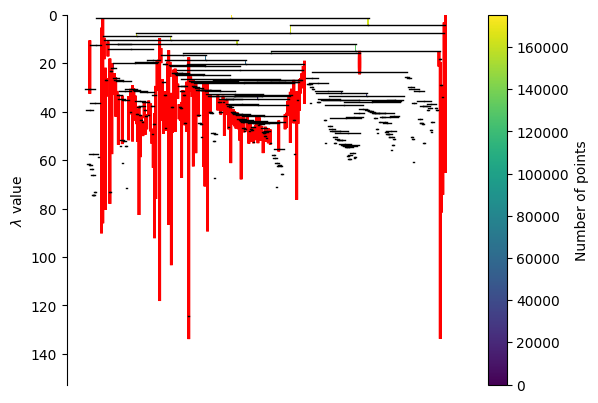

In [17]:
# import sns.color_palette()
import seaborn as sns

hdbscan.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [18]:
model.visualize_barchart(top_n_topics=12)

In [19]:
# import plotly.express as px

# u = UMAP(n_neighbors=15, n_components=3, min_dist=0, metric='cosine').fit_transform(embeded_sentences_new)

# fig = px.scatter_3d(x=u[:,0], y=u[:,1], z=u[:,2], color=topics, opacity=0.5, custom_data=[df['title']])

# fig.update_traces(
#     hovertemplate="<br>".join([
#         "Topic: %{marker.color}",
#         "Title: %{customdata[0]}"
#     ])
# )

In [20]:
# import plotly.express as px

# u = UMAP(n_neighbors=15, n_components=3, min_dist=0.5, metric='cosine').fit_transform(embeded_sentences_new)

# fig = px.scatter_3d(x=u[:,0], y=u[:,1], z=u[:,2], color=topics, opacity=0.5, custom_data=[df['title']])

# fig.update_traces(
#     hovertemplate="<br>".join([
#         "Topic: %{marker.color}",
#         "Title: %{customdata[0]}"
#     ])
# )

In [21]:
# # Do the same but in 2D
# u = UMAP(n_neighbors=15, n_components=2, min_dist=0.5, metric='cosine').fit_transform(embeded_sentences_new)

# fig = px.scatter(x=u[:,0], y=u[:,1], color=topics, opacity=0.5, custom_data=[df['title']])

# fig.update_traces(
#     hovertemplate="<br>".join([
#         "Topic: %{marker.color}",
#         "Title: %{customdata[0]}"
#     ])
# )

In [22]:
# # Do the same but in 2D
# u = UMAP(n_neighbors=30, n_components=2, min_dist=0, metric='cosine').fit_transform(embeded_sentences_new)

# fig = px.scatter(x=u[:,0], y=u[:,1], color=topics, opacity=0.5, custom_data=[df['title']])

# fig.update_traces(
#     hovertemplate="<br>".join([
#         "Topic: %{marker.color}",
#         "Title: %{customdata[0]}"
#     ])
# )

In [23]:
# # Do the same but in 2D
# u = UMAP(n_neighbors=30, n_components=2, min_dist=0.5, metric='cosine').fit_transform(embeded_sentences_new)

# fig = px.scatter(x=u[:,0], y=u[:,1], color=topics, opacity=0.5, custom_data=[df['title']])

# fig.update_traces(
#     hovertemplate="<br>".join([
#         "Topic: %{marker.color}",
#         "Title: %{customdata[0]}"
#     ])
# )

In [24]:
# import plotly.express as px

# u = UMAP(n_neighbors=30, n_components=3, min_dist=0, metric='cosine').fit_transform(embeded_sentences_new)

# fig = px.scatter_3d(x=u[:,0], y=u[:,1], z=u[:,2], color=topics, opacity=0.5, custom_data=[df['title']])

# fig.update_traces(
#     hovertemplate="<br>".join([
#         "Topic: %{marker.color}",
#         "Title: %{customdata[0]}"
#     ])
# )

In [25]:
# add the topics to the dataframe
df['topic'] = topics

In [26]:
# print couple of recipes from each topic
for topic in df['topic'].unique():
    if topic == 0:
        print(f'Topic {topic}:')
        display(df[df['topic'] == topic]['directions'].sample(5).tolist())
        print('\n')

Topic 0:


['["Fry bacon in a large stew pot.", "Remove bacon.", "Add stew meat and sear.", "Lower heat and add tomatoes, beef broth, water, celery, onion, garlic, Worcestershire sauce and chili powder.", "Cover and simmer 2 hours.", "Remove 1/4 cup broth from stew.", "Cool and mix with flour.", "Add flour mixture to stew.", "Season.", "Add carrots and potatoes and cook 30 minutes.", "Add corn and bacon.", "Cook another 5 minutes."]',
 '["Chop onions and saute in butter.", "Set aside.", "Cook bow ties according to package.", "Set aside.", "Boil and mash potatoes.", "Add Velveeta cheese which you have sliced.", "Mix well.", "Butter a 9 x 13-inch baking dish.", "Begin with 1/2 onion mixture on bottom of pan.", "Add 1/2 bow ties as the next layer, then 1/2 of the potatoes.", "Repeat ending with potatoes.", "Bake at 350\\u00b0 for 25 to 30 minutes."]',
 '["Cook together carrots, bouillon and water.", "Simmer sliced onions in butter.", "Add flour to thicken and water (drained from carrots).", "Add to 

In [27]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import nltk
from nltk.corpus import stopwords


In [28]:
def encode_directions(df_sample2):
    # Load the dataset

    # Convert the ingredients column to a list of lists
    transactions = df_sample2['directions'].to_numpy().tolist()
    transactions = [eval(x) for x in transactions]

    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    transactions_word_scale = []
    #nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    for transaction in transactions:
        recipe = []
        for sentence in transaction:
            # remove stop words and tokenize
            tokens = tokenizer.tokenize(sentence)
            # convert to lowercase, remove punctuation, and remove stop words
            tokens = [word.lower() for word in tokens if word.isalpha() and not word in stop_words]
            recipe += tokens
        transactions_word_scale.append(recipe)

    # Create a TransactionEncoder object to convert the list of lists into a one-hot encoded matrix
    te = TransactionEncoder()
    transactions_one_hot = te.fit(transactions_word_scale).transform(transactions_word_scale, sparse=True)
    # te_ary_word_scale = te.transform(transactions_word_scale)
    df_word_scale = pd.DataFrame.sparse.from_spmatrix(transactions_one_hot, columns=te.columns_)

    return df_sample2, df_word_scale

In [29]:
# run ARM for each topic

frequent_itemsets_word_per_topic = []

run_count = 0

# check if the file exists
if os.path.exists(f'{DATA_DIR}/frequent_itemsets_word_per_topic.pkl'):
    # load the file
    with open(f'{DATA_DIR}/frequent_itemsets_word_per_topic.pkl', 'rb') as f:
        frequent_itemsets_word_per_topic = pickle.load(f)
else:
    for topic in tqdm(df['topic'].unique()):
        if topic == -1:
            continue
        print(f'Run count: {run_count}')
        df_sample2 = df[df['topic'] == topic].copy()
        df_sample2, df_word_scale = encode_directions(df_sample2)
        frequent_itemsets_word_per_topic.append(fpgrowth(df_word_scale, min_support=0.01, use_colnames=True, max_len=5))
        run_count += 1
        if run_count == 5:
            break
    # save the file
    with open(f'{DATA_DIR}/frequent_itemsets_word_per_topic.pkl', 'wb') as f:
        pickle.dump(frequent_itemsets_word_per_topic, f)

In [32]:
topics = df['topic'].unique()
# run association rule mining for each topic
for i, freq_item_set in enumerate(frequent_itemsets_word_per_topic):
    topic = topics[i]
    if topic == -1 or 0:
        continue
    print(f'Topic: {topic}')
    rules = association_rules(freq_item_set, metric="support", min_threshold=0.25)
    display(rules.sort_values(by="lift", ascending=False).head(5))
    import networkx as nx
    import matplotlib.pyplot as plt
    # Create a network graph of the association rules

    # Only consider rules with lift greater than X
    filtered_rules = rules[rules.lift >= 1.20]

    G = nx.DiGraph()
    for i in tqdm(range(len(filtered_rules))):
        # add edge with an arrow from antecedents to consequents
        G.add_edge(filtered_rules.iloc[i]['antecedents'], filtered_rules.iloc[i]['consequents'], weight=filtered_rules.iloc[i]['lift'])

    # Apply page rank to the network graph
    page_rank = nx.pagerank(G)
    # Sort the recipes by page rank
    #sorted(page_rank.items(), key=lambda x: x[1], reverse=True)[:25]
    with open(f'dataset/rules_extracted_topic_{topic}.txt', 'w') as f:
        for recipe in sorted(page_rank.items(), key=lambda x: x[1], reverse=True)[:25]:
            f.write(f"Recipe: {recipe[0]}\n")
            # Find the most important 5 neighbors of the recipe
            neighbors = sorted(G[recipe[0]].items(), key=lambda x: x[1]['weight'], reverse=True)[:10]
            # Combine the sets of all neighbors into one list sorted by weight
            all_neighbors = sorted([(neighbor[0], neighbor[1]['weight']) for neighbor in neighbors], key=lambda x: x[1], reverse=True)
            # Eliminate weights
            all_neighbors = [neighbor[0] for neighbor in all_neighbors]
            # Combine all sets into one set
            new_all_neighbors = set()
            for neighbor in all_neighbors:
                new_all_neighbors = new_all_neighbors.union(neighbor)
            # Write to a file
            f.write(f"Neighbors: {new_all_neighbors}\n")
            f.write('\n')
    G.clear()

Topic: 83


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
63796,"(wrap, baking, cream)","(dish, bacon)",0.280822,0.520548,0.273973,0.975610,1.874198,0.127791,19.657534,0.648571
63809,"(dish, bacon)","(wrap, baking, cream)",0.520548,0.280822,0.273973,0.526316,1.874198,0.127791,1.518265,0.972857
64632,"(wrap, baking, sour)","(dish, bacon)",0.273973,0.520548,0.267123,0.975000,1.873026,0.124507,19.178082,0.641993
64637,"(dish, bacon)","(wrap, baking, sour)",0.520548,0.273973,0.267123,0.513158,1.873026,0.124507,1.491300,0.972161
65598,"(hours, dish, bacon)","(wrap, baking)",0.465753,0.301370,0.260274,0.558824,1.854278,0.119910,1.583562,0.862348


  0%|          | 0/8190 [00:00<?, ?it/s]

Topic: 1


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,"(chicken, bake)",(dish),0.519271,0.319017,0.261415,0.503426,1.578051,0.095758,1.371361,0.761983
30,(dish),"(chicken, bake)",0.319017,0.519271,0.261415,0.819437,1.578051,0.095758,2.662388,0.537910
26,"(chicken, dish)",(bake),0.316476,0.524269,0.261415,0.826017,1.575559,0.095496,2.734353,0.534443
31,(bake),"(chicken, dish)",0.524269,0.316476,0.261415,0.498627,1.575559,0.095496,1.363303,0.767881
24,(dish),(bake),0.319017,0.524269,0.263363,0.825544,1.574657,0.096112,2.726943,0.535904


  0%|          | 0/18 [00:00<?, ?it/s]

Topic: 0


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
24,(cheese),"(minutes, bake)",0.376514,0.422048,0.252177,0.669769,1.586951,0.093271,1.750147,0.593214
21,"(minutes, bake)",(cheese),0.422048,0.376514,0.252177,0.597509,1.586951,0.093271,1.549068,0.639951
20,"(minutes, cheese)",(bake),0.329332,0.513849,0.252177,0.765724,1.490175,0.082951,2.075125,0.490463
25,(bake),"(minutes, cheese)",0.513849,0.329332,0.252177,0.490762,1.490175,0.082951,1.317003,0.676616
19,(bake),(cheese),0.513849,0.376514,0.279587,0.544103,1.445109,0.086116,1.367605,0.633570


  0%|          | 0/12 [00:00<?, ?it/s]

Topic: 58


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
28,(dissolve),(water),0.304160,0.506612,0.271700,0.893281,1.763244,0.117609,4.623227,0.622073
29,(water),(dissolve),0.506612,0.304160,0.271700,0.536308,1.763244,0.117609,1.500651,0.877329
22,"(add, pineapple)",(water),0.426545,0.506612,0.273864,0.642052,1.267344,0.057771,1.378378,0.367855
27,(water),"(add, pineapple)",0.506612,0.426545,0.273864,0.540579,1.267344,0.057771,1.248213,0.427550
25,(add),"(pineapple, water)",0.724693,0.304160,0.273864,0.377903,1.242450,0.053441,1.118540,0.708805


  0%|          | 0/6 [00:00<?, ?it/s]